# Training: Quantum case

## Preparation

We start with importing NumPy and specifying some training hyperparameters.

In [22]:
import os
import warnings

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [23]:
import numpy as np

BATCH_SIZE = 10
EPOCHS = 100
SEED = 2

### Input data

Let's read the data and print some example sentences.

In [24]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('../data/restaurant_v2_train.txt')
val_labels, val_data = read_data('../data/restaurant_v2_dev.txt')
test_labels, test_data = read_data('../data/restaurant_v2_test.txt')

In [25]:
import os

TESTING = False

if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    val_labels, val_data = val_labels[:2], val_data[:2]
    test_labels, test_data = test_labels[:2], test_data[:2]
    EPOCHS = 10

In [26]:
train_data[:5]

['I love the restaurant',
 'I dislike the restaurant',
 'I loved the great food',
 'I loved the nice food',
 'I loved the tasty food']

In [27]:
train_labels[:5]

[[1, 0], [0, 1], [1, 0], [1, 0], [1, 0]]

### Creating and parameterising diagrams

In [28]:
from lambeq import BobcatParser

parser = BobcatParser(root_cats=('NP', 'N'), verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


### Filter and simplify diagrams

In [29]:
train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]
test_diagrams = [
    diagram.normal_form()
    for diagram in raw_test_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, train_labels)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, val_labels)
    if diagram is not None
]
test_labels = [
    label for (diagram, label)
    in zip(raw_test_diagrams, test_labels)
    if diagram is not None
]

Let's see the form of the diagram for a relative clause on the subject of a sentence:

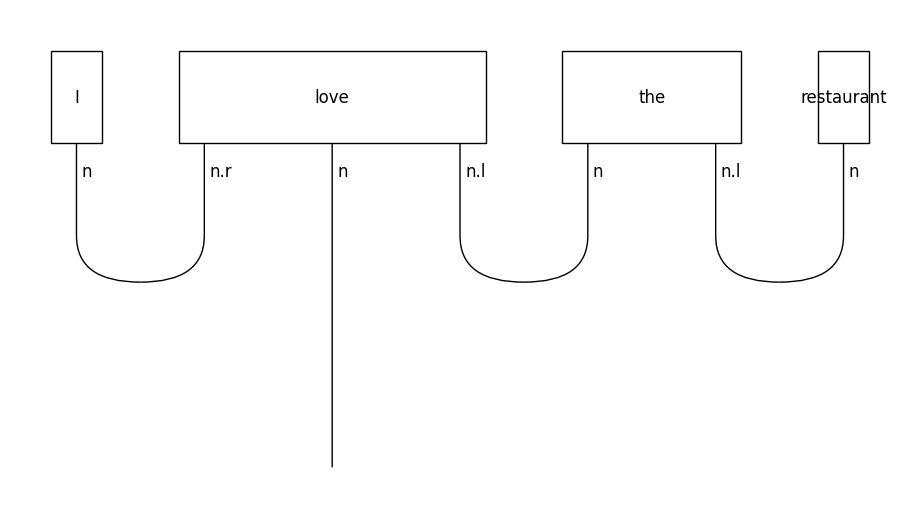

In [30]:
train_diagrams[0].draw(figsize=(9, 5), fontsize=12)

In object-based relative clauses the noun that follows the relative pronoun is the object of the sentence:

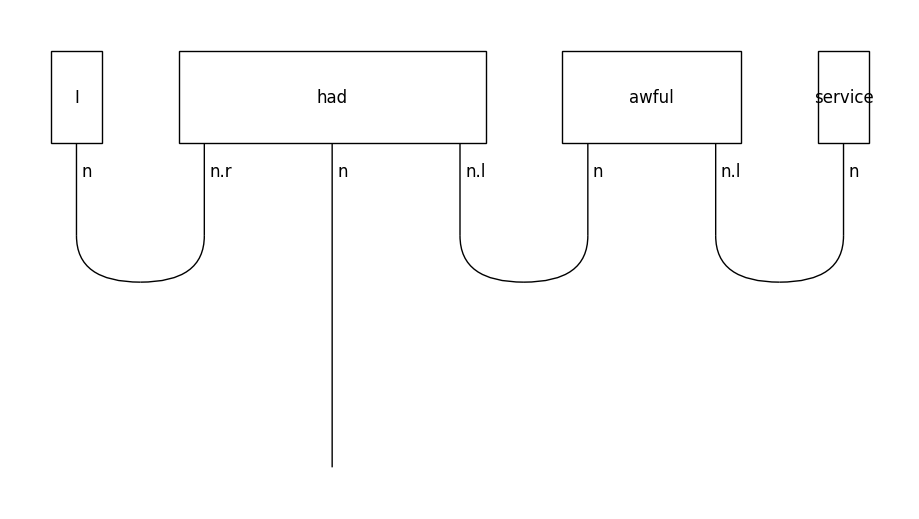

In [31]:
train_diagrams[-1].draw(figsize=(9, 5), fontsize=12)

### Create circuits

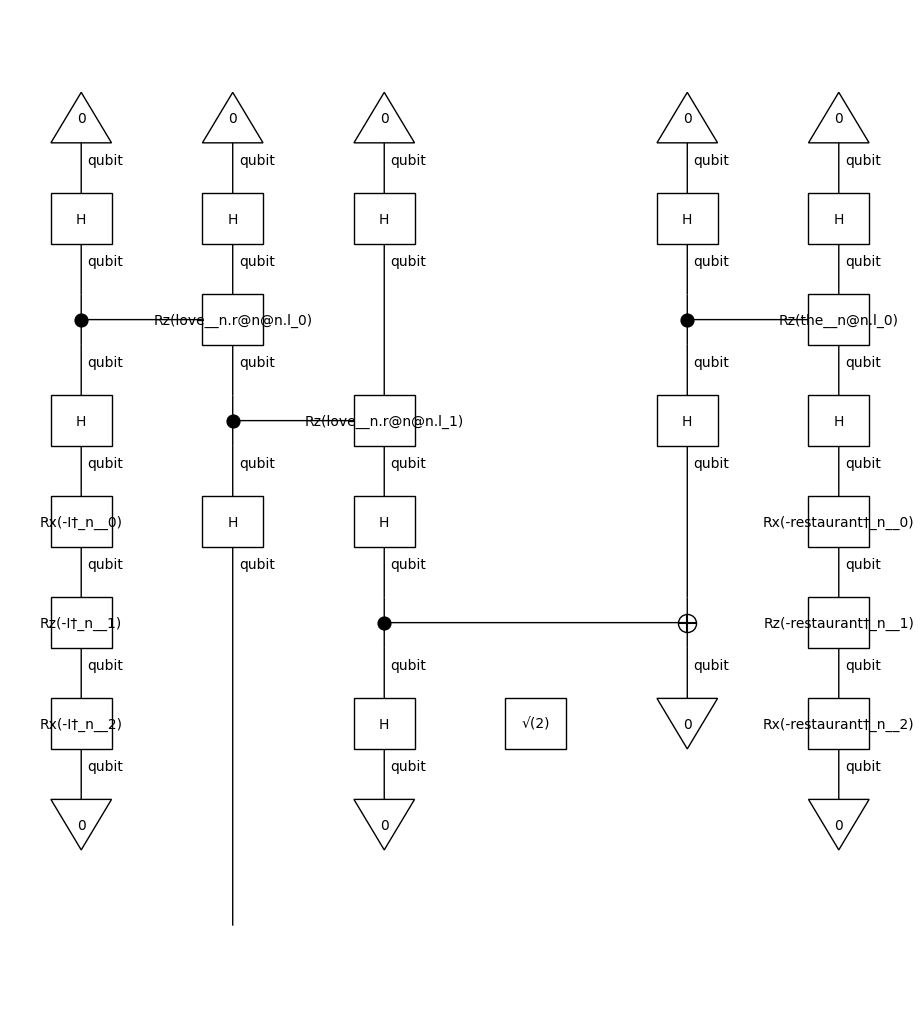

In [32]:
from lambeq import AtomicType, IQPAnsatz, RemoveCupsRewriter

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 0},
                   n_layers=1, n_single_qubit_params=3)
remove_cups = RemoveCupsRewriter()

train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
val_circuits =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams]
test_circuits =  [ansatz(remove_cups(diagram))  for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 10))

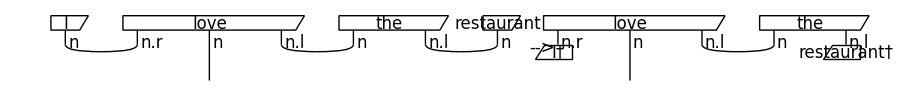

In [33]:
from lambeq.backend import draw_equation

original_diagram = train_diagrams[0]
removed_cups_diagram = remove_cups(original_diagram)

draw_equation(original_diagram, removed_cups_diagram, symbol='-->', figsize=(9, 6), asymmetry=0.3, fontsize=12)

## Training
### Instantiate the model

In [34]:
from pytket.extensions.qiskit import AerBackend, IBMQEmulatorBackend, set_ibmq_config
from lambeq import TketModel, PennyLaneModel

all_circuits = train_circuits + val_circuits + test_circuits

# if no backend_config is provided, the default is used, which is the same as below
backend_config = {'backend': 'default.qubit'}   # this is the default PennyLane simulator
model = PennyLaneModel.from_diagrams(all_circuits,
                                     probabilities=True,
                                     normalize=True,
                                     backend_config=backend_config)
model.initialise_weights()

### Define loss and evaluation metric

In [35]:
import torch

def acc(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.mse_loss(y_hat, y)

### Initialise trainer

In [36]:
from lambeq import PytorchTrainer

BATCH_SIZE = 10
EPOCHS = 100
LEARNING_RATE = 0.1
SEED = 42

trainer = PytorchTrainer(
    model=model,
    loss_function=loss,
    optimizer=torch.optim.Adam,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

### Create datasets

In [37]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

### Train

In [38]:
trainer.fit(train_dataset, val_dataset,
            minimize_criterion=False)

Epoch 1:    train/loss: 0.5112   valid/loss: 0.3627   train/acc: 0.4737   valid/acc: 0.5667
Epoch 2:    train/loss: 0.3228   valid/loss: 0.2698   train/acc: 0.6974   valid/acc: 0.6333
Epoch 3:    train/loss: 0.2452   valid/loss: 0.1375   train/acc: 0.7632   valid/acc: 0.8000
Epoch 4:    train/loss: 0.1423   valid/loss: 0.1389   train/acc: 0.7632   valid/acc: 0.8333
Epoch 5:    train/loss: 0.1077   valid/loss: 0.1257   train/acc: 0.8026   valid/acc: 0.8667
Epoch 6:    train/loss: 0.0973   valid/loss: 0.1469   train/acc: 0.8816   valid/acc: 0.7667
Epoch 7:    train/loss: 0.0327   valid/loss: 0.1327   train/acc: 0.8947   valid/acc: 0.7333
Epoch 8:    train/loss: 0.2427   valid/loss: 0.1029   train/acc: 0.9079   valid/acc: 0.9000
Epoch 9:    train/loss: 0.0005   valid/loss: 0.0880   train/acc: 0.8947   valid/acc: 0.8667
Epoch 10:   train/loss: 0.0026   valid/loss: 0.1004   train/acc: 0.9474   valid/acc: 0.8667
Epoch 11:   train/loss: 0.0292   valid/loss: 0.0967   train/acc: 0.9605   valid/

## Results

Finally, we visualise the results and evaluate the model on the test data.

Final test accuracy: 0.9666666666666667


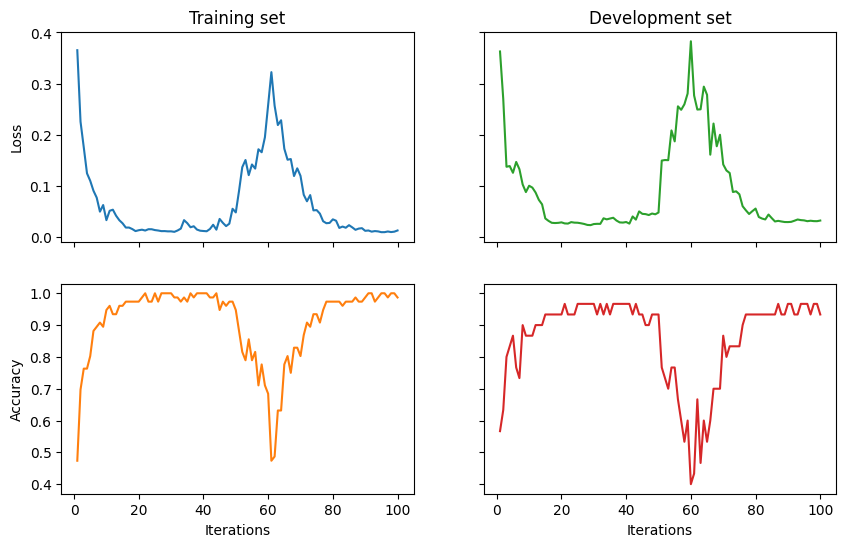

In [40]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
pred = model(test_circuits)
labels = torch.tensor(test_labels)

print('Final test accuracy: {}'.format(acc(pred, labels)))

In [41]:
def accuracy(circs, labels):
    probs = model(circs)
    return (torch.argmax(probs, dim=1) ==
            torch.argmax(torch.tensor(labels), dim=1)).sum().item()/len(circs)

print('Final test accuracy: {}'.format(accuracy(test_circuits, test_labels)))


Final test accuracy: 0.9666666666666667
